# Pizza or Not Pizza 분류(VGG 안 쓴 버전)
- ImageFolder
- Transforms
- DataLoader
- CNN
- weight

In [2]:
# 모듈 로딩
import pandas as pd
import numpy as np

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler


import torch
import torch.nn as nn
import torch.nn.functional as F

C:\Users\kdp\anaconda3\envs\Torch_PY38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 데이터 불러오기

In [3]:
from torchvision.datasets import ImageFolder 

train_root = "../data/project_img/train" # 해당 경로 내에 있는 파일명이 곧 label이 되는 것
val_root = "../data/project_img/validation"
test_root = "../data/project_img/test"


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocessing = transforms.Compose([
    transforms.Resize((50, 50), interpolation=transforms.InterpolationMode.BILINEAR), # 1. resize
    # transforms.CenterCrop(224), # 2. 중앙크롭
    transforms.ToTensor(),  # 3. 값의 크기를 0~1로
    transforms.Normalize(mean=mean, std=std) # 4. normalized
])

trainDS = ImageFolder(root=train_root, transform=preprocessing)
valDS = ImageFolder(root=val_root, transform=preprocessing)
testDS = ImageFolder(root=test_root, transform=preprocessing)

## 데이터 셋이 잘 읽혔는지 확인

In [4]:
trainDS.classes, trainDS.class_to_idx

(['not_pizza', 'pizza'], {'not_pizza': 0, 'pizza': 1})

In [5]:
valDS.classes, valDS.class_to_idx

(['not_pizza', 'pizza'], {'not_pizza': 0, 'pizza': 1})

In [6]:
testDS.classes, testDS.class_to_idx

(['not_pizza', 'pizza'], {'not_pizza': 0, 'pizza': 1})

In [7]:
# 비율 확인
len(trainDS), len(valDS), len(testDS)

(1600, 200, 166)

In [8]:
# def make_weights(labels, nclasses):
#     labels = np.array(labels)   # where, unique 함수를 사용하기 위해 numpy로 변환한다.
#     weight_list = []   # 가중치를 저장하는 배열을 생성한다.
#  
#     for cls in range(nclasses):
#         idx = np.where(labels == cls)[0]
#         count = len(idx)    #각 클래스 데이터 수 카운트 
#         weight = 1/count    
#         weights = [weight] * count    #라벨이 뽑힐 가중치를 1/count로 동일하게 전체 라벨에 할당 
#         weight_list += weights
#  
#     return weight_list


In [9]:
# sampler -> 각 배치의 분포를 맞추기 위함 
# weights = make_weights(imgDS.targets, len(imgDS.classes))
weights = torch.ones(len(trainDS.targets), dtype=torch.float)
# print(weights)
sampler = WeightedRandomSampler(weights, len(weights))

train_DL = DataLoader(trainDS, batch_size=50, sampler=sampler)
val_DL = DataLoader(valDS, batch_size=20) 
test_DL = DataLoader(testDS)

max = 10
for cnt, (_, label) in enumerate(train_DL):
    print(f'batch별 target 분포\n{label.bincount()}\n')
    if cnt > max:
        break

batch별 target 분포
tensor([26, 24])

batch별 target 분포
tensor([28, 22])
batch별 target 분포
tensor([23, 27])

batch별 target 분포
tensor([26, 24])
batch별 target 분포
tensor([27, 23])

batch별 target 분포
tensor([25, 25])
batch별 target 분포
tensor([25, 25])

batch별 target 분포
tensor([31, 19])
batch별 target 분포
tensor([19, 31])

batch별 target 분포
tensor([22, 28])
batch별 target 분포
tensor([24, 26])

batch별 target 분포
tensor([21, 29])


In [10]:
len(train_DL), len(val_DL), len(test_DL) # 배치 개수

(32, 10, 166)

# 직접 하는 CNN

In [11]:
### ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.0  Device: cpu


In [12]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__() # in rgb, 커널은 8개 준비고했고 사이즈는 3*3짜리얌
#         self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1) # 커널이 8개면 결과도 8개 
#         self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
#         # 풀링을 줘서 줄임
#         self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
#         self.fc1 = nn.Linear(12*12*16, 8)
#         self.fc2 = nn.Linear(8, 4)
#         self.fc3 = nn.Linear(4, 1)
#         self.sigmoid  = nn.Sigmoid() 
#         
#         
#     def forward(self, x):
#         x = self.conv1(x) # 패딩이랑 커널사이즈 때문에 row, col의 크기는 변화 X => 50 50 8
#         x = F.relu(x)
#         x = self.pool(x) # pooling 때문에 반갈죽 => 25 25 8
#         x = self.conv2(x) # 25 25 16
#         x = F.relu(x)
#         x = self.pool(x) # pooling 또 반갈죽 => 12 12 16
#         
#         x = x.view(-1, 12*12*16)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = self.sigmoid(x) # sigmoid
#         return x
    
    
class CNN(nn.Module):
    def __init__(self,input_shape=3,output_shape=1):
        super().__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=64,stride=1,padding=1,kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        height = (50-3+2*1)/1 + 1
        self.layer2=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,stride=1,padding=1,kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        height = (height-3+2*1)/1 + 1
        height = int(height/2)
        
        self.layer3=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,stride=1,padding=1,kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        height = (height-3+2*1)/1 + 1
        
        self.layer4=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=128,stride=1,padding=1,kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        height = (height-3+2*1)/1 + 1
        height = int(height/2)
        
        height = (height-3+2*1)/1 + 1
        self.layer5=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,stride=1,padding=1,kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        height = (height-3+2*1)/1 + 1
        
        self.layer6=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=256,stride=1,padding=1,kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        height = (height-3+2*1)/1 + 1
        
        self.layer7=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=256,stride=1,padding=1,kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        height = (height-3+2*1)/1 + 1
        height = int(height/2)

        self.layer8=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,padding=1,kernel_size=3,stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        height = (height-3+2*1)/1 + 1

        self.layer9=nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512,padding=1,stride=1,kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        height = (height-3+2*1)/1 + 1

        self.layer10=nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512,padding=1,stride=1,kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        height = (height-3+2*1)/1 + 1
        height = int(height/2)

        self.layer11=nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512,padding=1,stride=1,kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        height = (height-3+2*1)/1 + 1

        self.layer12=nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512,padding=1,stride=1,kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        height = (height-3+2*1)/1 + 1

        self.layer13=nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512,padding=1,stride=1,kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        height = (height-3+2*1)/1 + 1
        height = int(height/2)
        print(height)
        
        self.fc1=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(height*height*512,4096),
            nn.ReLU()
        )
        self.fc2=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU()
        )
        self.fc3=nn.Sequential(
            nn.Linear(4096,output_shape),
            nn.Sigmoid() 
        )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [13]:
### ===> Optimizer, Objective Function 설정
model = CNN().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = nn.BCELoss() # 

print(model)

1
CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [14]:
# CNN 모델 학습 진행 함수
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        # label = label.unsqueeze(dim=1).dtype(torch.)
        
        optimizer.zero_grad()
        output = model(image)
        label = label.float()
        
        # print("=============output================")
        # print(output)
        # print("==============label===============")
        # print(label)
        loss = criterion(output, label.unsqueeze(dim = 1))
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")

In [15]:
### 검증 validation 진행 함수 
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            label = label.float()
            output = model(image)
            test_loss += criterion(output, label.unsqueeze(dim = 1)).item()
            # print(output.max(1, keepdim = True))
            prediction = output.round()  # 이진 분류에서는 반올림하여 0 또는 1로 변환
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset) # 평균 손실 
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 학습 진행

In [16]:
# CNN 학습
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    
    train(epoch, model, train_DL, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_DL)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

Train Epoch: 1 [0]	Train Loss: 0.691722

[EPOCH: 1], 	Test Loss: 1.1291, 	Test Accuracy: 42.17 % 
Train Epoch: 2 [0]	Train Loss: 0.691939

[EPOCH: 2], 	Test Loss: 0.7103, 	Test Accuracy: 60.24 % 
Train Epoch: 3 [0]	Train Loss: 0.670548

[EPOCH: 3], 	Test Loss: 0.6923, 	Test Accuracy: 53.01 % 
Train Epoch: 4 [0]	Train Loss: 0.692976

[EPOCH: 4], 	Test Loss: 0.7154, 	Test Accuracy: 52.41 % 
Train Epoch: 5 [0]	Train Loss: 0.737092

[EPOCH: 5], 	Test Loss: 0.6960, 	Test Accuracy: 50.60 % 
Train Epoch: 6 [0]	Train Loss: 0.671131

[EPOCH: 6], 	Test Loss: 0.6563, 	Test Accuracy: 59.64 % 
Train Epoch: 7 [0]	Train Loss: 0.697671

[EPOCH: 7], 	Test Loss: 0.6778, 	Test Accuracy: 57.83 % 
Train Epoch: 8 [0]	Train Loss: 0.677613

[EPOCH: 8], 	Test Loss: 0.6720, 	Test Accuracy: 63.25 % 
Train Epoch: 9 [0]	Train Loss: 0.666936

[EPOCH: 9], 	Test Loss: 0.6767, 	Test Accuracy: 66.87 % 
Train Epoch: 10 [0]	Train Loss: 0.683369

[EPOCH: 10], 	Test Loss: 0.6262, 	Test Accuracy: 65.66 % 


# 예측 진행 : 피자

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 1, 50, 50] to have 3 channels, but got 1 channels instead

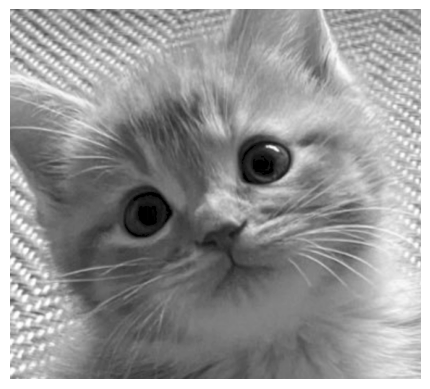

In [17]:
import cv2
import matplotlib.pyplot as plt


dongle = cv2.imread('../data/img/img3.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(dongle, cmap = 'gray')
plt.axis("off")
dongle = cv2.resize(dongle, (50, 50)) / 255

dongle = np.expand_dims(dongle, axis=0) # (50, 50) -> (1, 50, 50)

model(torch.FloatTensor(dongle)) # 아슬아슬하게 고양이가 된 동글이!! 이 정도면 제비뽑기를 하는 것이 나아보인다ㅠㅠ